## 1. Import Library

In [20]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import joblib
import random
import warnings
warnings.filterwarnings('ignore')

## 2. Load Model

In [21]:
model_path = r"d:\kuliah\SMT5\Mlearning\MLearning\model_sayuran.pkl"
sample_path = r"d:\kuliah\SMT5\Mlearning\MLearning\sample"

# Load model package
model_package = joblib.load(model_path)

model = model_package['model']
scaler = model_package['scaler']
pca = model_package['pca']
label_encoder = model_package['label_encoder']
best_params = model_package['best_params']
best_ratio = model_package['split_ratio']
performance = model_package['performance']

print(f"Model load")
print(f"Best Split Ratio: {best_ratio}")
print(f"Best Parameters: {best_params}")
print(f"\nPerforma Model:")
print(f"Train Accuracy: {performance['train']['accuracy']:.4f}")
print(f"Test Accuracy: {performance['test']['accuracy']:.4f}")

Model load
Best Split Ratio: 90:10
Best Parameters: {'C': 0.42, 'gamma': 'scale', 'kernel': 'rbf'}

Performa Model:
Train Accuracy: 0.8628
Test Accuracy: 0.7627


## 3. Fungsi Preprocessing

In [22]:
def crop_image(image, crop_ratio=0.1):
    h, w = image.shape[:2]
    crop_h = int(h * crop_ratio)
    crop_w = int(w * crop_ratio)
    cropped = image[crop_h:h-crop_h, crop_w:w-crop_w]
    return cropped

def resize_image(image, target_size=(128, 128)):
    resized = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
    return resized

def adjust_contrast_brightness(image, alpha=1.2, beta=0.1):
    adjusted = np.clip(alpha * image + beta, 0, 1)
    return adjusted

def apply_gaussian_blur(image, kernel_size=(5, 5)):
    if image.max() <= 1:
        image = (image * 255).astype(np.uint8)
    blurred = cv2.GaussianBlur(image, kernel_size, 0)
    return blurred.astype(np.float32) / 255.0

def preprocess_image(image_path):
    # Read image
    img = cv2.imread(image_path)
    
    # Crop
    img = crop_image(img, crop_ratio=0.1)
    
    # Resize
    img = resize_image(img, target_size=(128, 128))
    
    # Enhancement
    img_float = img.astype(np.float32) / 255.0
    img_contrast = adjust_contrast_brightness(img_float, alpha=1.2, beta=0.1)
    img_blurred = apply_gaussian_blur(img_contrast)
    img_normalized = np.clip(img_blurred, 0, 1)
    
    return img_normalized

print("Fungsi preprocessing siap!")

Fungsi preprocessing siap!


Total gambar dalam folder sample: 72

Gambar yang dipilih: ['1205.jpg', '1448.jpg', '1243.jpg', '1379.jpg', '1204.jpg']



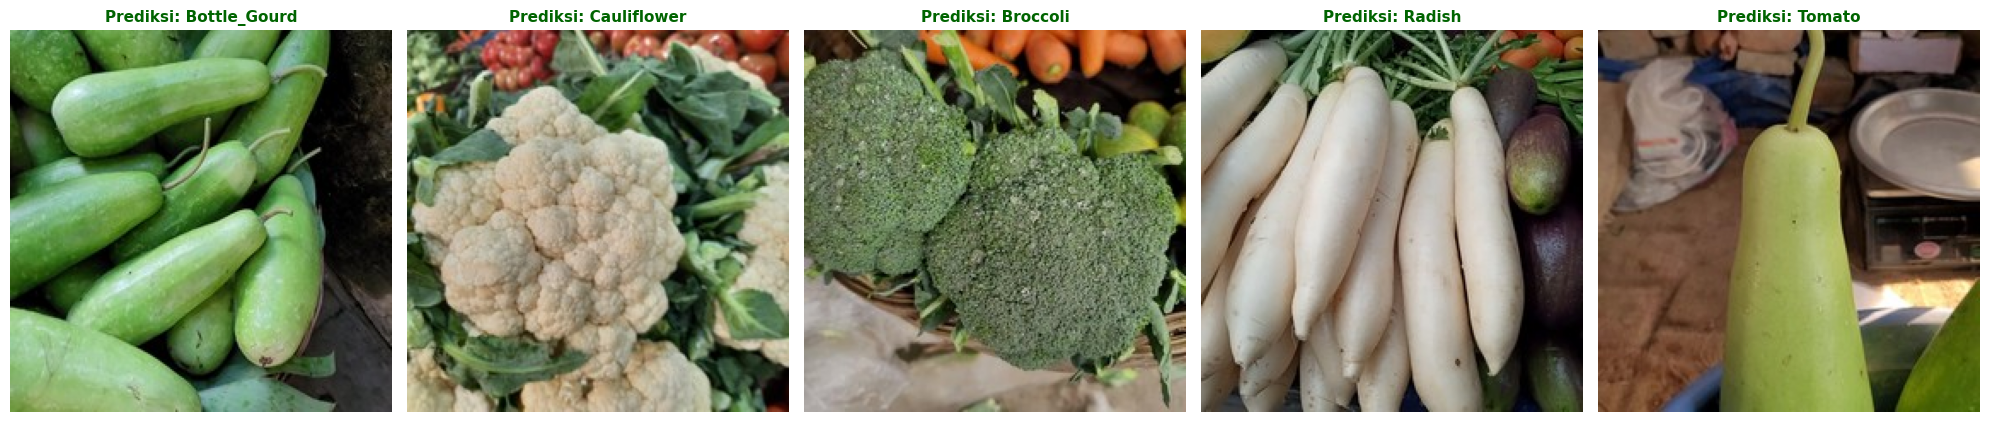

Hasil Prediksi:
1205.jpg             -> Bottle_Gourd
1448.jpg             -> Cauliflower
1243.jpg             -> Broccoli
1379.jpg             -> Radish
1204.jpg             -> Tomato


In [23]:
# Get list of all image files in sample folder
image_files = [f for f in os.listdir(sample_path) if f.endswith('.jpg') or f.endswith('.png')]

print(f"Total gambar dalam folder sample: {len(image_files)}\n")

# Select 5 random images
random.seed()
selected_files = random.sample(image_files, min(5, len(image_files)))

print(f"Gambar yang dipilih: {selected_files}\n")

# Preprocess, predict dan visualisasi
predictions = []
images_display = []

for img_file in selected_files:
    img_path = os.path.join(sample_path, img_file)
    
    # Read original image for display
    img_original = cv2.imread(img_path)
    images_display.append(img_original)
    
    # Preprocess image
    img_preprocessed = preprocess_image(img_path)
    
    # Flatten dan extract features
    img_flattened = img_preprocessed.flatten().reshape(1, -1)
    
    # Apply PCA
    img_pca = pca.transform(img_flattened)
    
    # Scale
    img_scaled = scaler.transform(img_pca)
    
    # Predict
    prediction_encoded = model.predict(img_scaled)[0]
    
    # Decode prediction
    prediction_class = label_encoder.inverse_transform([prediction_encoded])[0]
    
    predictions.append(prediction_class)

# Visualisasi
fig, axes = plt.subplots(1, 5, figsize=(20, 5))

for idx, (ax, img_file, img_display, prediction) in enumerate(zip(axes, selected_files, images_display, predictions)):
    # Convert BGR to RGB for display
    img_rgb = cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB)
    
    ax.imshow(img_rgb)
    ax.set_title(f"Prediksi: {prediction}", fontsize=11, fontweight='bold', color='darkgreen')
    ax.set_xlabel(f"File: {img_file}", fontsize=9)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Ringkasan hasil

print("Hasil Prediksi:")
for img_file, prediction in zip(selected_files, predictions):
    print(f"{img_file:20} -> {prediction}")